In [88]:
import numpy as np
import pandas as pd

# maps
import geopandas as gpd
from geopandas import GeoDataFrame
import polyline
from shapely.geometry import Point, LineString, MultiLineString

# plot
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy
from collections import Counter
%matplotlib inline
sns.set_style("darkgrid")

#sklearn
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

In [31]:
traffic_18_m = pd.read_csv('traffic_18_m.csv')

In [32]:
traffic_18_m.columns

Index(['Unnamed: 0', 'index', 'ID', 'SPEED', 'TRAVEL_TIME', 'STATUS',
       'DATA_AS_OF', 'LINK_ID', 'LINK_POINTS', 'ENCODED_POLY_LINE',
       'ENCODED_POLY_LINE_LVLS', 'OWNER', 'TRANSCOM_ID', 'BOROUGH',
       'LINK_NAME', 'year', 'month', 'dayofweek', 'RecordedAtTime', 'hour',
       'minute', 'poly_num', 'LINK_START', 'LINK_END', 'LINK_MIDDLE',
       'speed_id', 'speed_limit', 'lion_id', 'Street', 'FeatureTyp',
       'SegmentTyp', 'RB_Layer', 'NonPed', 'TrafDir', 'SeqNum', 'StreetCode',
       'StreetWidt', 'BikeLane', 'Snow_Prior', 'Number_Tra', 'Number_Tot',
       'Join_ID', 'weekend', 'morn_rush_hr', 'eve_rush_hr',
       'morning_rush_avg_spd', 'evening_rush_avg_spd', 'wknd_avg_spd',
       'overall_avg_spd', 'overall_std_speed', 'speed_index'],
      dtype='object')

In [33]:
traffic_18_m = traffic_18_m.drop(['Unnamed: 0', 'index'],1)
traffic_18_m.head()

,ID,SPEED,TRAVEL_TIME,STATUS,DATA_AS_OF,LINK_ID,LINK_POINTS,ENCODED_POLY_LINE,ENCODED_POLY_LINE_LVLS,OWNER,...,Join_ID,weekend,morn_rush_hr,eve_rush_hr,morning_rush_avg_spd,evening_rush_avg_spd,wknd_avg_spd,overall_avg_spd,overall_std_speed,speed_index
0,423,47.22,113,0,2018-12-31 23:58:23,4616299,"40.7624804,-73.839391 40.76191,-73.839121 40.7...",olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,...,4474001042223,0,0,0,40.762976,34.937478,49.801891,46.591828,11.256594,0
1,423,47.84,112,0,2018-12-31 23:53:22,4616299,"40.7624804,-73.839391 40.76191,-73.839121 40.7...",olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,...,4474001042223,0,0,0,40.762976,34.937478,49.801891,46.591828,11.256594,0
2,423,47.84,112,0,2018-12-31 23:48:24,4616299,"40.7624804,-73.839391 40.76191,-73.839121 40.7...",olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,...,4474001042223,0,0,0,40.762976,34.937478,49.801891,46.591828,11.256594,0
3,423,46.60,115,0,2018-12-31 23:43:23,4616299,"40.7624804,-73.839391 40.76191,-73.839121 40.7...",olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,...,4474001042223,0,0,0,40.762976,34.937478,49.801891,46.591828,11.256594,0
4,423,45.36,118,0,2018-12-31 23:38:24,4616299,"40.7624804,-73.839391 40.76191,-73.839121 40.7...",olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,...,4474001042223,0,0,0,40.762976,34.937478,49.801891,46.591828,11.256594,0


In [34]:
traffic_18_m['RecordedAtTime']

0           23:58:23
1           23:53:22
2           23:48:24
3           23:43:23
4           23:38:24
5           23:33:23
6           23:28:23
7           23:23:24
8           23:18:24
9           23:13:24
10          23:08:23
11          23:03:24
12          22:58:25
13          22:53:23
14          22:48:25
15          22:43:24
16          22:38:27
17          22:33:24
18          22:28:25
19          22:23:25
20          22:18:24
21          22:13:24
22          22:08:24
23          22:03:24
24          21:58:25
25          21:53:24
26          21:48:25
27          21:43:25
28          21:38:24
29          21:33:26
              ...   
13345314    02:27:13
13345315    02:22:12
13345316    02:17:14
13345317    02:12:13
13345318    02:07:12
13345319    02:02:14
13345320    01:57:13
13345321    01:52:14
13345322    01:47:13
13345323    01:42:12
13345324    01:37:13
13345325    01:32:12
13345326    01:27:13
13345327    01:22:12
13345328    01:17:14
13345329    01:12:12
13345330    0

In [35]:
traffic_18_m['DATA_AS_OF'] = pd.DatetimeIndex(traffic_18_m['DATA_AS_OF'])

In [45]:
traffic_18_m['DATA_AS_OF']

0          2018-12-31 23:58:23
1          2018-12-31 23:53:22
2          2018-12-31 23:48:24
3          2018-12-31 23:43:23
4          2018-12-31 23:38:24
5          2018-12-31 23:33:23
6          2018-12-31 23:28:23
7          2018-12-31 23:23:24
8          2018-12-31 23:18:24
9          2018-12-31 23:13:24
10         2018-12-31 23:08:23
11         2018-12-31 23:03:24
12         2018-12-31 22:58:25
13         2018-12-31 22:53:23
14         2018-12-31 22:48:25
15         2018-12-31 22:43:24
16         2018-12-31 22:38:27
17         2018-12-31 22:33:24
18         2018-12-31 22:28:25
19         2018-12-31 22:23:25
20         2018-12-31 22:18:24
21         2018-12-31 22:13:24
22         2018-12-31 22:08:24
23         2018-12-31 22:03:24
24         2018-12-31 21:58:25
25         2018-12-31 21:53:24
26         2018-12-31 21:48:25
27         2018-12-31 21:43:25
28         2018-12-31 21:38:24
29         2018-12-31 21:33:26
                   ...        
13345314   2018-01-01 02:27:13
13345315

In [50]:
traffic_sample = traffic_18_m.loc[(traffic_18_m['DATA_AS_OF']<'2018-06-1')&(traffic_18_m['DATA_AS_OF']>='2018-05-01')]

traffic_sample = traffic_sample.drop(columns=['LINK_POINTS','ENCODED_POLY_LINE','ENCODED_POLY_LINE_LVLS','TRANSCOM_ID','Join_ID'])

In [51]:
traffic_sample['DATA_AS_OF']

60353      2018-05-31 23:58:10
60354      2018-05-31 23:53:11
60355      2018-05-31 23:48:11
60356      2018-05-31 23:43:10
60357      2018-05-31 23:39:10
60358      2018-05-31 23:33:09
60359      2018-05-31 23:28:09
60360      2018-05-31 23:23:11
60361      2018-05-31 23:18:10
60362      2018-05-31 23:12:10
60363      2018-05-31 23:07:11
60364      2018-05-31 23:02:15
60365      2018-05-31 22:57:11
60366      2018-05-31 22:52:10
60367      2018-05-31 22:47:10
60368      2018-05-31 22:42:12
60369      2018-05-31 22:37:11
60370      2018-05-31 22:32:10
60371      2018-05-31 22:27:12
60372      2018-05-31 22:22:11
60373      2018-05-31 22:17:12
60374      2018-05-31 22:12:11
60375      2018-05-31 22:07:10
60376      2018-05-31 22:03:10
60377      2018-05-31 21:58:10
60378      2018-05-31 21:53:11
60379      2018-05-31 21:48:10
60380      2018-05-31 21:43:11
60381      2018-05-31 21:38:11
60382      2018-05-31 21:33:11
                   ...        
13311319   2018-05-01 02:28:04
13311320

In [52]:
traffic_sample.shape

(1079068, 44)

In [53]:
traffic_sample.columns

Index(['ID', 'SPEED', 'TRAVEL_TIME', 'STATUS', 'DATA_AS_OF', 'LINK_ID',
       'OWNER', 'BOROUGH', 'LINK_NAME', 'year', 'month', 'dayofweek',
       'RecordedAtTime', 'hour', 'minute', 'poly_num', 'LINK_START',
       'LINK_END', 'LINK_MIDDLE', 'speed_id', 'speed_limit', 'lion_id',
       'Street', 'FeatureTyp', 'SegmentTyp', 'RB_Layer', 'NonPed', 'TrafDir',
       'SeqNum', 'StreetCode', 'StreetWidt', 'BikeLane', 'Snow_Prior',
       'Number_Tra', 'Number_Tot', 'weekend', 'morn_rush_hr', 'eve_rush_hr',
       'morning_rush_avg_spd', 'evening_rush_avg_spd', 'wknd_avg_spd',
       'overall_avg_spd', 'overall_std_speed', 'speed_index'],
      dtype='object')

In [54]:
traffic_sample.speed_index.value_counts()

 0     280803
 5     142657
-40     99288
-5      91606
-30     75030
-10     72011
-15     61276
 10     60839
-20     54546
-25     54537
 15     33253
 25     22972
 30     15204
 20     15046
Name: speed_index, dtype: int64

In [55]:
traffic_s = traffic_sample.sample(frac=1, random_state=1)

traffic_ex = pd.DataFrame(columns=traffic_s.columns)

for i in traffic_s.speed_index.unique():
    label = traffic_s.loc[traffic_s['speed_index']==i][:50000]
    traffic_ex = pd.concat([traffic_ex, label])
    
traffic_ex.speed_index.value_counts()

-5     50000
-10    50000
-15    50000
-20    50000
-25    50000
-30    50000
-40    50000
 10    50000
 5     50000
 0     50000
 15    33253
 25    22972
 30    15204
 20    15046
Name: speed_index, dtype: int64

In [56]:
traffic_ex.shape

(586475, 44)

In [58]:
traffic_sample = traffic_ex

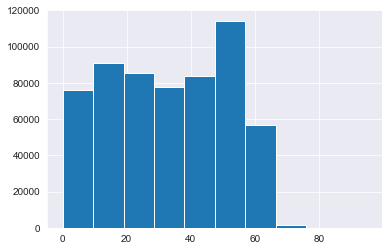

In [59]:
traffic_sample.SPEED.hist()

In [55]:
traffic_sample.speed_index.value_counts()

-40    107411
-30    107305
-20    107302
 10    107220
 5     107203
-10    107191
 25    107184
-5     107158
 30    107154
 15    107112
-15    107022
 20    106966
 0     106909
-25    106863
Name: speed_index, dtype: int64

In [60]:
tonumeric = ['Number_Tot','Number_Tra','SeqNum','StreetCode','lion_id','speed_id','speed_limit']
tocategory = ['Snow_Prior','NonPed','RB_Layer','SegmentTyp','FeatureTyp','Street','BOROUGH']

# turn columns into numberic
for i in tonumeric:
    traffic_sample[i] = pd.to_numeric(traffic_sample[i])

# to a category then immediately into a coded column
for i in tocategory:
    traffic_sample[i] = traffic_sample[i].astype('category')
    traffic_sample[i+'_codes'] = traffic_sample[i].cat.codes
    
traffic_sample.head()

,ID,SPEED,TRAVEL_TIME,STATUS,DATA_AS_OF,LINK_ID,OWNER,BOROUGH,LINK_NAME,year,...,overall_avg_spd,overall_std_speed,speed_index,Snow_Prior_codes,NonPed_codes,RB_Layer_codes,SegmentTyp_codes,FeatureTyp_codes,Street_codes,BOROUGH_codes
3771382,142,37.28,200,0,2018-05-13 19:13:11,4616261,NYC_DOT_LIC,Bronx,BE S Griswold - Castle Hill Avenue,2018,...,43.220017,14.232058,-10,0,1,0,0,0,6,0
3150870,129,39.14,118,0,2018-05-21 12:48:10,4616246,NYC_DOT_LIC,Bronx,BE N STRATFORD AVENUE - CASTLE HILL AVE,2018,...,50.483482,10.406435,-10,0,1,0,0,0,6,0
10759563,445,14.29,400,0,2018-05-31 12:38:03,4456494,NYC_DOT_LIC,Manhattan,West St S Spring St - BBT Manhattan Portal out...,2018,...,8.276728,8.073302,-10,1,-1,0,4,0,29,2
2945621,106,13.67,160,0,2018-05-18 11:23:03,4616323,NYC_DOT_LIC,Manhattan,12th Ave S 57th St - 45th St,2018,...,9.596084,7.391987,-10,2,-1,0,4,0,0,2
4698323,344,37.90,117,0,2018-05-05 05:53:03,4620330,NYC_DOT_LIC,Bronx,MDE S HARLEM RIVER PARK - GWB W AMSTERDAM AVEN...,2018,...,21.705855,13.039449,-10,0,1,1,1,0,19,0


___

In [61]:
nullvals = pd.DataFrame(traffic_sample.isna().sum())
nullvals

,0
ID,0
SPEED,0
TRAVEL_TIME,0
STATUS,0
DATA_AS_OF,0
LINK_ID,0
OWNER,0
BOROUGH,0
LINK_NAME,0
year,0


In [62]:
traffic_sample = traffic_sample.drop(columns='NonPed')
traffic_sample = traffic_sample.dropna()

## Regression

Add the mean squared error matrix into here

In [63]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

X = traffic_sample.drop(['SPEED', 'DATA_AS_OF','OWNER', 'BOROUGH','LINK_NAME','RecordedAtTime',
                         'LINK_START','LINK_END','LINK_MIDDLE','Street', 'FeatureTyp', 'SegmentTyp', 
                         'RB_Layer', 'TrafDir','Snow_Prior','speed_index', 'TRAVEL_TIME'], 1)
y = traffic_sample['SPEED']

selector=SelectKBest(score_func=f_classif, k=30)
selector.fit(X,y)
scores = pd.DataFrame()
scores["Attribute"] = X.columns
scores["F Score"] = selector.scores_
scores["P Value"] = selector.pvalues_
scores["Support"] = selector.get_support()

scores = scores.sort_values(by=['F Score'], ascending=False)

key_vals = scores.Attribute.loc[scores['P Value']<.05].values

scores.loc[scores['P Value']<.05].reset_index()

/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 3  4 15 30] are constant.
  UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,index,Attribute,F Score,P Value,Support
0,1,STATUS,14819.905066,0.000000e+00,True
1,24,overall_avg_spd,4816.336433,0.000000e+00,True
2,23,wknd_avg_spd,4472.455731,0.000000e+00,True
3,22,evening_rush_avg_spd,3961.666449,0.000000e+00,True
4,21,morning_rush_avg_spd,3562.254300,0.000000e+00,True
5,13,StreetCode,1017.946351,0.000000e+00,True
6,11,lion_id,742.190799,0.000000e+00,True
7,0,ID,694.701391,0.000000e+00,True
8,31,Street_codes,641.177499,0.000000e+00,True
9,26,Snow_Prior_codes,581.335386,0.000000e+00,True


In [64]:
X = traffic_sample[key_vals]
y = traffic_sample['SPEED']

from sklearn import preprocessing

#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(X,y)

#X = preprocessing.scale(X)
#y = StandardScaler().fit_transform(y)

# to split a training and test sample
from sklearn.model_selection import train_test_split, cross_val_score
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### Linear Regression

In [65]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x_train, y_train)

ypred = reg.predict(x_test)

print('test score:')
print(reg.score(x_train, y_train))

print('\ntrain score:')
print(reg.score(x_test, y_test))

print('Coefficients:')
print(reg.coef_)

print('\nCoefficients Mean:')
print(reg.coef_.mean())

print('\nCoefficients Standard Deviation:')
print(reg.coef_.std())

print('\nIntercept:')
print(reg.intercept_)


cross_val = cross_val_score(reg, x_train, y_train, cv = 5)
print('\nCross Validation Score:')
print(cross_val)

print('\nCross Validation Mean:')
print(cross_val.mean())

print('\nCross Validation Standard Deviation:')
print(cross_val.std())

test score:
0.6167978698045254

train score:
0.6146523310862615
Coefficients:
[ 1.78939783e-01  7.91718612e-01 -4.73102671e-01  2.43382882e-01
  2.14718457e-01  1.09572848e-05 -1.51928729e-05  9.38585713e-03
 -1.48503107e-02 -2.58278011e+00  1.03541704e-01  7.38446736e-02
 -4.23742901e-02  3.93553415e-01 -9.93954248e-05  4.40294824e-01
  5.80111309e-03  1.78870559e-07 -3.15557020e-01  3.26312519e-06
 -7.47271419e+00  7.40853094e-01  1.22782898e-01  1.29613728e-01
 -1.66820699e+00 -8.74106807e+00  2.66413280e+00 -8.68127124e-01
  5.02591044e-04]

Coefficients Mean:
-0.5539936048133114

Coefficients Standard Deviation:
2.218166840184391

Intercept:
-1.6956136789890124

Cross Validation Score:
[0.61652452 0.61859412 0.61504528 0.61359977 0.61992376]

Cross Validation Mean:
0.6167374914283578

Cross Validation Standard Deviation:
0.0022958061693689065


#### Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf_regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100)

rf_regr.fit(x_train, y_train)

ypred = rf_regr.predict(x_test)

print('test score:')
print(rf_regr.score(x_train, y_train))

print('\ntrain score:')
print(rf_regr.score(x_test, y_test))

print('\nFeature Importances:')
print(rf_regr.feature_importances_)



cross_val = cross_val_score(rf_regr, x_train, y_train, cv = 5)
print('\nCross Validation Score:')
print(cross_val)

print('\nCross Validation Mean:')
print(cross_val.mean())

print('\nCross Validation Standard Deviation:')
print(cross_val.std())

test score:
0.6544526317577971

train score:
0.6565815108852273

Feature Importances:
[2.85746867e-01 6.01087021e-01 3.16531578e-02 1.01449578e-04
 2.70825143e-04 7.73239428e-03 2.92314890e-04 0.00000000e+00
 0.00000000e+00 9.16749940e-03 2.38858568e-03 0.00000000e+00
 0.00000000e+00 9.98955637e-05 2.08553192e-03 0.00000000e+00
 7.00113622e-03 2.03103971e-04 1.63681621e-04 4.83458693e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.66066673e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]

Cross Validation Score:
[0.65434702 0.65714644 0.65372169 0.65157125 0.66178386]

Cross Validation Mean:
0.655714052179476

Cross Validation Standard Deviation:
0.0035183904265563303


In [132]:
# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'n_estimators':[50,75,100,125,150,200,300], 'max_depth':[6,8,10,12]}

# Start the grid search again
grid_DT = GridSearchCV(rf_regr, param_grid, cv=3, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed: 501.9min finished


Best score for data: {'max_depth': 12, 'n_estimators': 125}


In [66]:
from sklearn.ensemble import RandomForestRegressor

rf_regr = RandomForestRegressor(max_depth=12, random_state=0, n_estimators=125)

rf_regr.fit(x_train, y_train)

ypred = rf_regr.predict(x_test)

print('test score:')
print(rf_regr.score(x_train, y_train))

print('\ntrain score:')
print(rf_regr.score(x_test, y_test))

print('\nFeature Importances:')
print(rf_regr.feature_importances_)



cross_val = cross_val_score(rf_regr, x_train, y_train, cv = 5)
print('\nCross Validation Score:')
print(cross_val)

print('\nCross Validation Mean:')
print(cross_val.mean())

print('\nCross Validation Standard Deviation:')
print(cross_val.std())

test score:
0.8220039170788623

train score:
0.8103069422625714

Feature Importances:
[1.54548804e-01 5.14669931e-01 2.48721989e-02 2.03129621e-02
 2.41526594e-02 6.50865724e-03 5.74315916e-03 1.20332612e-02
 6.08506362e-03 3.19877084e-05 1.45586521e-02 8.99061680e-04
 6.67954418e-03 2.06117846e-05 3.27139748e-03 4.38718454e-04
 4.20877692e-03 6.73877101e-03 1.30745947e-01 6.22101992e-03
 1.27940517e-02 2.81425993e-04 1.61831713e-03 2.76779134e-04
 3.00243726e-04 8.59142785e-03 5.73690909e-03 2.25498701e-02
 5.10978950e-03]

Cross Validation Score:
[0.81210275 0.81303773 0.81023395 0.81077509 0.8124293 ]

Cross Validation Mean:
0.8117157615301483

Cross Validation Standard Deviation:
0.0010475785174139023


#### K Nearest Neighbors

In [68]:
from sklearn.neighbors import KNeighborsRegressor

In [73]:
k_regr = KNeighborsRegressor(n_neighbors=25)

k_regr.fit(x_train, y_train)

ypred = k_regr.predict(x_test)

print('test score:')
print(k_regr.score(x_train, y_train))

print('\ntrain score:')
print(k_regr.score(x_test, y_test))


cross_val = cross_val_score(k_regr, x_train, y_train, cv = 5)
print('\nCross Validation Score:')
print(cross_val)

print('\nCross Validation Mean:')
print(cross_val.mean())

print('\nCross Validation Standard Deviation:')
print(cross_val.std())

test score:
0.8027061740513234

train score:
0.782298593801053

Cross Validation Score:
[0.7759505  0.77526116 0.77258732 0.77313044 0.77497922]

Cross Validation Mean:
0.7743817248738316

Cross Validation Standard Deviation:
0.0012943765713137243


In [70]:
from sklearn.model_selection import GridSearchCV

k_regr = KNeighborsRegressor(n_neighbors=25)

# import KNN
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=50)

#GridSearchCV for random forest
param_grid = {'n_neighbors':[25,50,75,150,300,500,750]}

# Start the grid search again
grid_DT = GridSearchCV(k_regr, param_grid, cv=3, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [71]:
from sklearn.model_selection import GridSearchCV

k_regr = KNeighborsRegressor(n_neighbors=25)

# import KNN
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=50)

#GridSearchCV for random forest
param_grid = {'n_neighbors':[5,10,15,25]}

# Start the grid search again
grid_DT = GridSearchCV(k_regr, param_grid, cv=3, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 15.9min finished


Best score for data: {'n_neighbors': 10}


In [72]:
k_regr = KNeighborsRegressor(n_neighbors=10)

k_regr.fit(x_train, y_train)

ypred = k_regr.predict(x_test)

print('test score:')
print(k_regr.score(x_train, y_train))

print('\ntrain score:')
print(k_regr.score(x_test, y_test))


cross_val = cross_val_score(k_regr, x_train, y_train, cv = 5)
print('\nCross Validation Score:')
print(cross_val)

print('\nCross Validation Mean:')
print(cross_val.mean())

print('\nCross Validation Standard Deviation:')
print(cross_val.std())

test score:
0.8361873573941164

train score:
0.7955570214926391

Cross Validation Score:
[0.79334018 0.79327705 0.79099601 0.79054426 0.79115603]

Cross Validation Mean:
0.791862706659303

Cross Validation Standard Deviation:
0.001197678335480948


#### Gradient Boosted Decision Tree

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

gb_regr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=0, loss='ls')

gb_regr.fit(x_train, y_train)

ypred = gb_regr.predict(x_test)

print('test score:')
print(gb_regr.score(x_train, y_train))

print('\ntrain score:')
print(gb_regr.score(x_test, y_test))


cross_val = cross_val_score(gb_regr, x_train, y_train, cv = 5)
print('\nCross Validation Score:')
print(cross_val)

print('\nCross Validation Mean:')
print(cross_val.mean())

print('\nCross Validation Standard Deviation:')
print(cross_val.std())

test score:
0.7575573763787654

train score:
0.7587749496228641

Cross Validation Score:
[0.75569669 0.75691412 0.75572913 0.75366305 0.7610865 ]

Cross Validation Mean:
0.7566178972693416

Cross Validation Standard Deviation:
0.002466809992119436


## Classification

Add area under curve to here

In [81]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

X = traffic_sample.drop(['SPEED', 'DATA_AS_OF','OWNER', 'BOROUGH','LINK_NAME','RecordedAtTime',
                         'LINK_START','LINK_END','LINK_MIDDLE','Street', 'FeatureTyp', 'SegmentTyp', 
                         'RB_Layer', 'TrafDir','Snow_Prior','speed_index', 'TRAVEL_TIME'], 1)
y = traffic_sample['speed_index']

selector=SelectKBest(score_func=f_classif, k=31)
selector.fit(X,y)
scores = pd.DataFrame()
scores["Attribute"] = X.columns
scores["F Score"] = selector.scores_
scores["P Value"] = selector.pvalues_
scores["Support"] = selector.get_support()

scores = scores.sort_values(by=['F Score'], ascending=False)

key_vals = scores.Attribute.loc[scores['P Value']<.05].values

scores.loc[scores['P Value']<.05].reset_index()

/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 3  4 15 30] are constant.
  UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,index,Attribute,F Score,P Value,Support
0,1,STATUS,34470.512710,0.000000e+00,True
1,10,speed_limit,33891.659068,0.000000e+00,True
2,22,evening_rush_avg_spd,27335.009641,0.000000e+00,True
3,24,overall_avg_spd,26855.849882,0.000000e+00,True
4,23,wknd_avg_spd,25028.803442,0.000000e+00,True
5,21,morning_rush_avg_spd,20679.885470,0.000000e+00,True
6,27,NonPed_codes,10616.649775,0.000000e+00,True
7,13,StreetCode,9002.521571,0.000000e+00,True
8,11,lion_id,8882.911942,0.000000e+00,True
9,31,Street_codes,6777.900247,0.000000e+00,True


In [82]:
traffic_sample['speed_index'] = traffic_sample['speed_index'].astype('category')

In [83]:
X = traffic_sample[key_vals]
y = traffic_sample['speed_index']

# to split a training and test sample
from sklearn.model_selection import train_test_split, cross_val_score
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### Naive Bayes

In [105]:
from sklearn.metrics import classification_report

In [106]:
from datetime import datetime
start_time = datetime.now()

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
# Set Up Predictor
ypred_bnb = bnb.predict(x_test)

print('\nTrain Percentage accuracy:')
print(bnb.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(bnb.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(bnb, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_bnb))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.1763008802880943

Test Percentage accuracy:
0.17604130433299914

Cross Validation:
[0.17718066 0.17600455 0.17643515 0.17595235 0.17562467]

Classification Report:

              precision    recall  f1-score   support

         -40       0.20      0.21      0.21     12287
         -30       0.17      0.36      0.23     12604
         -25       0.15      0.03      0.05     12503
         -20       0.10      0.01      0.02     12488
         -15       0.00      0.00      0.00     12442
         -10       0.34      0.17      0.22     12524
          -5       0.14      0.12      0.13     12670
           0       0.19      0.13      0.15     12496
           5       0.12      0.25      0.16     12475
          10       0.13      0.45      0.20     12602
          15       0.32      0.01      0.02      8351
          20       0.27      0.01      0.01      3744
          25       0.57      0.42      0.49      5671
          30       0.79      0.42      0.55     

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [90]:
auc = roc_auc_score(y_test, ypred_bnb)
print('\nArea Under Curve:')
print('AUC: %.3f' % auc)

ValueError: multiclass format is not supported

#### KNN

In [79]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=50)
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.5172715616019788

Test Percentage accuracy:
0.49106868823276656

Cross Validation:
[0.48517811 0.48699062 0.48330113 0.48494322 0.48699498]

Classification Report:

              precision    recall  f1-score   support

         -40       0.77      0.88      0.82     12287
         -30       0.37      0.56      0.45     12604
         -25       0.39      0.38      0.38     12503
         -20       0.30      0.28      0.29     12488
         -15       0.31      0.24      0.27     12442
         -10       0.40      0.29      0.33     12524
          -5       0.45      0.36      0.40     12670
           0       0.49      0.43      0.46     12496
           5       0.55      0.60      0.57     12475
          10       0.57      0.60      0.59     12602
          15       0.63      0.70      0.66      8351
          20       0.47      0.37      0.41      3744
          25       0.60      0.82      0.69      5671
          30       0.77      0.67      0.71     

In [72]:
from sklearn.model_selection import GridSearchCV

# import KNN
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=50)

#GridSearchCV for random forest
param_grid = {'n_neighbors':[50,75,150,300,500,750]}

# Start the grid search again
grid_DT = GridSearchCV(knn, param_grid, cv=2, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 174.6min finished


Best score for data: {'n_neighbors': 50}


In [91]:
from sklearn.model_selection import GridSearchCV

# import KNN
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=50)

#GridSearchCV for random forest
param_grid = {'n_neighbors':[5,10,20,35,50]}

# Start the grid search again
grid_DT = GridSearchCV(knn, param_grid, cv=2, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 16.8min finished


Best score for data: {'n_neighbors': 10}


In [92]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.5952152522643774

Test Percentage accuracy:
0.5082765535162564

Cross Validation:
[0.50337584 0.50066496 0.50101171 0.50184728 0.50165973]

Classification Report:

              precision    recall  f1-score   support

         -40       0.79      0.88      0.84     12287
         -30       0.43      0.56      0.49     12604
         -25       0.38      0.41      0.40     12503
         -20       0.31      0.32      0.31     12488
         -15       0.32      0.28      0.30     12442
         -10       0.38      0.32      0.35     12524
          -5       0.44      0.37      0.41     12670
           0       0.52      0.44      0.48     12496
           5       0.60      0.60      0.60     12475
          10       0.62      0.64      0.63     12602
          15       0.66      0.69      0.67      8351
          20       0.51      0.42      0.46      3744
          25       0.63      0.76      0.69      5671
          30       0.77      0.69      0.73      

#### Decision Tree

In [69]:
start_time = datetime.now()
from sklearn import tree

dec_tr = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=20,
    random_state = 1337
)

dec_tr.fit(x_train, y_train)
# Set Up Predictor
ypred_dec_tr = dec_tr.predict(x_test)

print('\nTrain Percentage accuracy:')
print(dec_tr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(dec_tr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(dec_tr, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_dec_tr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6009031111111112

Test Percentage accuracy:
0.49480266666666667

Cross Validation:
[0.49605788 0.4888002  0.49050885 0.4889043  0.4921909 ]

Classification Report:

              precision    recall  f1-score   support

         -40       0.80      0.80      0.80     26809
         -30       0.39      0.52      0.45     26565
         -25       0.45      0.40      0.42     26971
         -20       0.29      0.29      0.29     26839
         -15       0.31      0.26      0.28     26639
         -10       0.34      0.28      0.31     26669
          -5       0.36      0.34      0.35     26612
           0       0.42      0.41      0.41     26720
           5       0.48      0.55      0.51     27014
          10       0.53      0.53      0.53     26873
          15       0.61      0.62      0.61     26950
          20       0.58      0.55      0.56     26657
          25       0.57      0.64      0.61     26943
          30       0.75      0.74      0.74     

#### Random Forest

In [70]:
from datetime import datetime
start_time = datetime.now()
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(n_estimators=50, max_depth=8)
rfc.fit(x_train, y_train)

ypred_rfc = rfc.predict(x_test)

print('\nTrain Percentage accuracy:')
print(rfc.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(rfc.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(rfc, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_rfc))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.4505697777777778

Test Percentage accuracy:
0.45056266666666667

Cross Validation:
[0.44733918 0.45014311 0.45467758 0.44807264 0.44605189]

Classification Report:
              precision    recall  f1-score   support

         -40       0.84      0.80      0.82     26809
         -30       0.28      0.54      0.37     26565
         -25       0.64      0.28      0.39     26971
         -20       0.23      0.35      0.28     26839
         -15       0.37      0.10      0.16     26639
         -10       0.41      0.17      0.24     26669
          -5       0.39      0.18      0.25     26612
           0       0.28      0.40      0.33     26720
           5       0.39      0.56      0.46     27014
          10       0.46      0.48      0.47     26873
          15       0.56      0.57      0.57     26950
          20       0.59      0.44      0.51     26657
          25       0.51      0.78      0.62     26943
          30       0.79      0.65      0.71     2

In [73]:
# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'n_estimators':[50,75,100,125,150,200,300], 'max_depth':[6,8,10,12]}

# Start the grid search again
grid_DT = GridSearchCV(rfc, param_grid, cv=2, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 2 folds for each of 28 candidates, totalling 56 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed: 110.6min finished


Best score for data: {'max_depth': 12, 'n_estimators': 100}


In [74]:
from datetime import datetime
start_time = datetime.now()
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(n_estimators=100, max_depth=12)
rfc.fit(x_train, y_train)

ypred_rfc = rfc.predict(x_test)

print('\nTrain Percentage accuracy:')
print(rfc.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(rfc.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(rfc, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_rfc))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.5113137777777778

Test Percentage accuracy:
0.5078373333333334

Cross Validation:
[0.50536875 0.50728431 0.50771337 0.50594452 0.50565793]

Classification Report:
              precision    recall  f1-score   support

         -40       0.82      0.85      0.83     26809
         -30       0.34      0.61      0.44     26565
         -25       0.59      0.34      0.43     26971
         -20       0.30      0.28      0.29     26839
         -15       0.39      0.21      0.27     26639
         -10       0.43      0.22      0.29     26669
          -5       0.35      0.37      0.36     26612
           0       0.39      0.47      0.42     26720
           5       0.48      0.58      0.53     27014
          10       0.54      0.52      0.53     26873
          15       0.61      0.66      0.63     26950
          20       0.63      0.52      0.57     26657
          25       0.55      0.75      0.64     26943
          30       0.78      0.72      0.75     26

#### Gradient Boosted Decision Tree

In [71]:
start_time = datetime.now()
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier(max_depth=5 , n_estimators=50 )
clf.fit(x_train, y_train)

ypred_clf = clf.predict(x_test)

print('\nTrain Percentage accuracy:')
print(clf.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(clf.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(clf, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_clf))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.5141937777777777

Test Percentage accuracy:
0.5132133333333333

Cross Validation:
[0.51179524 0.51163979 0.51394895 0.5114246  0.51232033]

Classification Report:
              precision    recall  f1-score   support

         -40       0.83      0.87      0.85     26809
         -30       0.39      0.56      0.46     26565
         -25       0.53      0.38      0.44     26971
         -20       0.30      0.29      0.30     26839
         -15       0.35      0.23      0.28     26639
         -10       0.38      0.26      0.31     26669
          -5       0.39      0.34      0.36     26612
           0       0.40      0.48      0.44     26720
           5       0.49      0.58      0.53     27014
          10       0.54      0.54      0.54     26873
          15       0.61      0.66      0.63     26950
          20       0.60      0.55      0.57     26657
          25       0.57      0.69      0.62     26943
          30       0.75      0.75      0.75     26

### Simplify the Classification Variable
Currently the speed index jumps at every 5mph, but because of the large amount of classes, the scores are coming out very low. As an attempt to raise accuracy, I am going to simplify what the model is predicting so it jumps at a rate of every 10mph.

In [97]:
limit = traffic_18_m['speed_limit']

traffic_18_m['speed_index'] = '~ Speed Limit'

# Minus
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']<=(traffic_18_m['speed_limit']-5))&
                                  (traffic_18_m['SPEED']>(traffic_18_m['speed_limit']-10))] = '5mph Under'
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']<=(traffic_18_m['speed_limit']-10))&
                                  (traffic_18_m['SPEED']>(traffic_18_m['speed_limit']-20))] = '10mph Under'
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']<=(traffic_18_m['speed_limit']-20))&
                                  (traffic_18_m['SPEED']>(traffic_18_m['speed_limit']-30))] = '20mph Under'
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']<=(traffic_18_m['speed_limit']-30))] = '30mph+ Under'


# Minus
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']>=(traffic_18_m['speed_limit']+5))&
                                  (traffic_18_m['SPEED']<(traffic_18_m['speed_limit']+10))] = '5mph Ober'
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']>=(traffic_18_m['speed_limit']+10))&
                                  (traffic_18_m['SPEED']<(traffic_18_m['speed_limit']+20))] = '10mph Over'
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']>=(traffic_18_m['speed_limit']+20))&
                                  (traffic_18_m['SPEED']<(traffic_18_m['speed_limit']+30))] = '20mph Over'
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']>=(traffic_18_m['speed_limit']+30))] = '30mph+ Over'

traffic_18_m['speed_index'].loc[traffic_18_m['SPEED']==0] = 'Stand Still'



traffic_18_m['speed_index'] = traffic_18_m['speed_index'].astype('category')

In [98]:
traffic_18_m['speed_index'].value_counts()

~ Speed Limit    3514785
10mph Under      1649383
5mph Ober        1618982
Stand Still      1327551
10mph Over       1223766
20mph Under      1171343
5mph Under       1106707
30mph+ Under     1105316
20mph Over        446950
30mph+ Over       180561
Name: speed_index, dtype: int64

In [99]:
traffic_s = traffic_18_m.sample(frac=1, random_state=1)

traffic_ex = pd.DataFrame(columns=traffic_s.columns)

for i in traffic_s.speed_index.unique():
    label = traffic_s.loc[traffic_s['speed_index']==i][:100000]
    traffic_ex = pd.concat([traffic_ex, label])
    
traffic_ex.speed_index.value_counts()

10mph Over       100000
20mph Over       100000
5mph Ober        100000
30mph+ Over      100000
30mph+ Under     100000
20mph Under      100000
10mph Under      100000
~ Speed Limit    100000
Stand Still      100000
5mph Under       100000
Name: speed_index, dtype: int64

In [100]:
traffic_ex = traffic_ex.drop(columns=['LINK_POINTS','ENCODED_POLY_LINE','ENCODED_POLY_LINE_LVLS','TRANSCOM_ID','Join_ID'])

In [101]:
tonumeric = ['Number_Tot','Number_Tra','SeqNum','StreetCode','lion_id','speed_id','speed_limit']
tocategory = ['Snow_Prior','NonPed','RB_Layer','SegmentTyp','FeatureTyp','Street','BOROUGH']

# turn columns into numberic
for i in tonumeric:
    traffic_ex[i] = pd.to_numeric(traffic_ex[i])

# to a category then immediately into a coded column
for i in tocategory:
    traffic_ex[i] = traffic_ex[i].astype('category')
    traffic_ex[i+'_codes'] = traffic_ex[i].cat.codes

In [103]:
traffic_ex = traffic_ex.drop(columns='NonPed')
traffic_ex = traffic_ex.dropna()

### Modeling

In [104]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

X = traffic_ex.drop(['SPEED', 'DATA_AS_OF','OWNER', 'BOROUGH','LINK_NAME','RecordedAtTime',
                     'LINK_START','LINK_END','LINK_MIDDLE','Street', 'FeatureTyp', 'SegmentTyp', 
                     'RB_Layer', 'TrafDir','Snow_Prior','speed_index', 'TRAVEL_TIME'], 1)
y = traffic_ex['speed_index']

selector=SelectKBest(score_func=f_classif, k=31)
selector.fit(X,y)
scores = pd.DataFrame()
scores["Attribute"] = X.columns
scores["F Score"] = selector.scores_
scores["P Value"] = selector.pvalues_
scores["Support"] = selector.get_support()

scores = scores.sort_values(by=['F Score'], ascending=False)

key_vals = scores.Attribute.loc[scores['P Value']<.05].values

scores.loc[scores['P Value']<.05].reset_index()

/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 3 15 30] are constant.
  UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,index,Attribute,F Score,P Value,Support
0,1,STATUS,358393.047861,0.000000e+00,True
1,10,speed_limit,160181.106667,0.000000e+00,True
2,24,overall_avg_spd,70668.360622,0.000000e+00,True
3,23,wknd_avg_spd,67254.777690,0.000000e+00,True
4,22,evening_rush_avg_spd,63928.128444,0.000000e+00,True
5,21,morning_rush_avg_spd,55753.488379,0.000000e+00,True
6,12,SeqNum,23170.301875,0.000000e+00,True
7,27,NonPed_codes,22694.379185,0.000000e+00,True
8,13,StreetCode,21543.949537,0.000000e+00,True
9,11,lion_id,19997.549981,0.000000e+00,True


In [107]:
X = traffic_ex[key_vals]
y = traffic_ex['speed_index']

# to split a training and test sample
from sklearn.model_selection import train_test_split, cross_val_score
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### Naive Bayes

In [108]:
from sklearn.metrics import classification_report

In [109]:
from datetime import datetime
start_time = datetime.now()

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
# Set Up Predictor
ypred_bnb = bnb.predict(x_test)

print('\nTrain Percentage accuracy:')
print(bnb.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(bnb.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(bnb, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_bnb))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.24840533333333334

Test Percentage accuracy:
0.247268

Cross Validation:
[0.24718008 0.24977    0.24923499 0.24802165 0.24803995]

Classification Report:



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


               precision    recall  f1-score   support

   10mph Over       0.13      0.08      0.10     25238
  10mph Under       0.34      0.18      0.24     25044
   20mph Over       0.58      0.46      0.51     24990
  20mph Under       0.20      0.28      0.24     24991
  30mph+ Over       0.55      0.39      0.46     25040
 30mph+ Under       0.35      0.26      0.30     24804
    5mph Ober       0.14      0.60      0.23     24976
   5mph Under       0.17      0.06      0.09     25071
  Stand Still       0.00      0.00      0.00     24823
~ Speed Limit       0.23      0.16      0.19     25023

    micro avg       0.25      0.25      0.25    250000
    macro avg       0.27      0.25      0.23    250000
 weighted avg       0.27      0.25      0.23    250000


Duration: 0:00:32.377359


#### KNN

In [110]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.7097973333333333

Test Percentage accuracy:
0.649524

Cross Validation:
[0.64457614 0.64649138 0.64694431 0.64777099 0.64734393]

Classification Report:

               precision    recall  f1-score   support

   10mph Over       0.71      0.77      0.74     25238
  10mph Under       0.46      0.47      0.46     25044
   20mph Over       0.74      0.77      0.76     24990
  20mph Under       0.49      0.50      0.49     24991
  30mph+ Over       0.83      0.84      0.83     25040
 30mph+ Under       0.64      0.64      0.64     24804
    5mph Ober       0.62      0.66      0.64     24976
   5mph Under       0.50      0.44      0.47     25071
  Stand Still       0.90      0.95      0.92     24823
~ Speed Limit       0.57      0.47      0.52     25023

    micro avg       0.65      0.65      0.65    250000
    macro avg       0.65      0.65      0.65    250000
 weighted avg       0.65      0.65      0.65    250000


Duration: 0:14:43.651408


In [72]:
from sklearn.model_selection import GridSearchCV

# import KNN
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=50)

#GridSearchCV for random forest
param_grid = {'n_neighbors':[50,75,150,300,500,750]}

# Start the grid search again
grid_DT = GridSearchCV(knn, param_grid, cv=2, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 174.6min finished


Best score for data: {'n_neighbors': 50}


In [91]:
from sklearn.model_selection import GridSearchCV

# import KNN
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=50)

#GridSearchCV for random forest
param_grid = {'n_neighbors':[5,10,20,35,50]}

# Start the grid search again
grid_DT = GridSearchCV(knn, param_grid, cv=2, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 16.8min finished


Best score for data: {'n_neighbors': 10}


In [92]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.5952152522643774

Test Percentage accuracy:
0.5082765535162564

Cross Validation:
[0.50337584 0.50066496 0.50101171 0.50184728 0.50165973]

Classification Report:

              precision    recall  f1-score   support

         -40       0.79      0.88      0.84     12287
         -30       0.43      0.56      0.49     12604
         -25       0.38      0.41      0.40     12503
         -20       0.31      0.32      0.31     12488
         -15       0.32      0.28      0.30     12442
         -10       0.38      0.32      0.35     12524
          -5       0.44      0.37      0.41     12670
           0       0.52      0.44      0.48     12496
           5       0.60      0.60      0.60     12475
          10       0.62      0.64      0.63     12602
          15       0.66      0.69      0.67      8351
          20       0.51      0.42      0.46      3744
          25       0.63      0.76      0.69      5671
          30       0.77      0.69      0.73      

#### Decision Tree

In [111]:
start_time = datetime.now()
from sklearn import tree

dec_tr = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=20,
    random_state = 1337
)

dec_tr.fit(x_train, y_train)
# Set Up Predictor
ypred_dec_tr = dec_tr.predict(x_test)

print('\nTrain Percentage accuracy:')
print(dec_tr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(dec_tr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(dec_tr, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_dec_tr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.7084893333333333

Test Percentage accuracy:
0.627952

Cross Validation:
[0.61597691 0.6199584  0.62433083 0.61621077 0.62054988]

Classification Report:

               precision    recall  f1-score   support

   10mph Over       0.70      0.73      0.71     25238
  10mph Under       0.44      0.43      0.43     25044
   20mph Over       0.75      0.75      0.75     24990
  20mph Under       0.46      0.48      0.47     24991
  30mph+ Over       0.82      0.86      0.84     25040
 30mph+ Under       0.61      0.61      0.61     24804
    5mph Ober       0.58      0.64      0.61     24976
   5mph Under       0.46      0.42      0.44     25071
  Stand Still       0.90      0.91      0.91     24823
~ Speed Limit       0.51      0.46      0.48     25023

    micro avg       0.63      0.63      0.63    250000
    macro avg       0.62      0.63      0.63    250000
 weighted avg       0.62      0.63      0.63    250000


Duration: 0:00:27.887555


#### Random Forest

In [112]:
from datetime import datetime
start_time = datetime.now()
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(n_estimators=50, max_depth=8)
rfc.fit(x_train, y_train)

ypred_rfc = rfc.predict(x_test)

print('\nTrain Percentage accuracy:')
print(rfc.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(rfc.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(rfc, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_rfc))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.5474546666666666

Test Percentage accuracy:
0.546468

Cross Validation:
[0.54657876 0.549766   0.54894366 0.54035694 0.54891464]

Classification Report:
               precision    recall  f1-score   support

   10mph Over       0.60      0.67      0.63     25238
  10mph Under       0.49      0.22      0.30     25044
   20mph Over       0.69      0.65      0.67     24990
  20mph Under       0.34      0.48      0.40     24991
  30mph+ Over       0.77      0.79      0.78     25040
 30mph+ Under       0.52      0.46      0.49     24804
    5mph Ober       0.45      0.63      0.53     24976
   5mph Under       0.51      0.17      0.26     25071
  Stand Still       0.84      0.97      0.90     24823
~ Speed Limit       0.33      0.43      0.37     25023

    micro avg       0.55      0.55      0.55    250000
    macro avg       0.55      0.55      0.53    250000
 weighted avg       0.55      0.55      0.53    250000


Duration: 0:04:22.333163


In [114]:
# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'n_estimators':[50,75,100,125,150,200], 'max_depth':[6,8,10,12]}

# Start the grid search again
grid_DT = GridSearchCV(rfc, param_grid, cv=2, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 1601.4min finished


Best score for data: {'max_depth': 12, 'n_estimators': 150}


In [115]:
from datetime import datetime
start_time = datetime.now()
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(n_estimators=150, max_depth=12)
rfc.fit(x_train, y_train)

ypred_rfc = rfc.predict(x_test)

print('\nTrain Percentage accuracy:')
print(rfc.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(rfc.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(rfc, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_rfc))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.61644

Test Percentage accuracy:
0.61124

Cross Validation:
[0.61002373 0.61073186 0.60948406 0.60885739 0.61044961]

Classification Report:
               precision    recall  f1-score   support

   10mph Over       0.69      0.71      0.70     25238
  10mph Under       0.52      0.31      0.39     25044
   20mph Over       0.72      0.76      0.74     24990
  20mph Under       0.42      0.48      0.45     24991
  30mph+ Over       0.81      0.82      0.82     25040
 30mph+ Under       0.59      0.57      0.58     24804
    5mph Ober       0.53      0.64      0.58     24976
   5mph Under       0.46      0.38      0.42     25071
  Stand Still       0.87      0.97      0.92     24823
~ Speed Limit       0.46      0.49      0.47     25023

    micro avg       0.61      0.61      0.61    250000
    macro avg       0.61      0.61      0.60    250000
 weighted avg       0.61      0.61      0.60    250000


Duration: 4:37:59.338157


#### Gradient Boosted Decision Tree

In [71]:
start_time = datetime.now()
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier(max_depth=5 , n_estimators=50 )
clf.fit(x_train, y_train)

ypred_clf = clf.predict(x_test)

print('\nTrain Percentage accuracy:')
print(clf.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(clf.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(clf, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_clf))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.5141937777777777

Test Percentage accuracy:
0.5132133333333333

Cross Validation:
[0.51179524 0.51163979 0.51394895 0.5114246  0.51232033]

Classification Report:
              precision    recall  f1-score   support

         -40       0.83      0.87      0.85     26809
         -30       0.39      0.56      0.46     26565
         -25       0.53      0.38      0.44     26971
         -20       0.30      0.29      0.30     26839
         -15       0.35      0.23      0.28     26639
         -10       0.38      0.26      0.31     26669
          -5       0.39      0.34      0.36     26612
           0       0.40      0.48      0.44     26720
           5       0.49      0.58      0.53     27014
          10       0.54      0.54      0.54     26873
          15       0.61      0.66      0.63     26950
          20       0.60      0.55      0.57     26657
          25       0.57      0.69      0.62     26943
          30       0.75      0.75      0.75     26

# Unsupervised

In [75]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

In [92]:
traffic_small = traffic_sample.sample(200000, random_state=1)
X_sample = traffic_small.drop(['SPEED', 'DATA_AS_OF','OWNER', 'BOROUGH','LINK_NAME','RecordedAtTime',
                               'LINK_START','LINK_END','LINK_MIDDLE','Street', 'FeatureTyp', 'SegmentTyp', 
                               'RB_Layer', 'TrafDir','Snow_Prior','speed_index', 'TRAVEL_TIME'], 1)

In [93]:
X_norm = normalize(X_sample)
# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)

X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

# Check the length of each set
print(len(X1), len(X_pca1))
print(len(X2), len(X_pca2))
print(len(X3), len(X_pca3))
print(len(X4), len(X_pca4))

50000 50000
50000 50000
50000 50000
50000 50000


In [94]:
# Initialize data frames
ypred_df = pd.DataFrame()
scores_df = pd.DataFrame(columns=['cluster_pred','sil_score'])

for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred_df['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred_df['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]

    
    # Creating a list of possible number of clusters to test in kmeans.
    for n_cluster in range(2, 10): 
        # Instantiating and fit_predicting model to then add to data frame
        kmeans = KMeans(n_clusters=n_cluster, random_state=42)
        pred = kmeans.fit_predict(data[0])
        ypred_df['cluster ' + str(n_cluster) + '_sample ' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = kmeans.labels_
        sscore = metrics.silhouette_score(data[0], labels, metric='euclidean')
        scores_df = scores_df.append({'cluster_pred':'cluster ' + str(n_cluster) + '_sample ' + str(counter), 
                              'sil_score':sscore}, ignore_index=True)

In [95]:
# Sorting sihoilette scores
scores_df.sort_values(by='sil_score', ascending=False)

,cluster_pred,sil_score
0,cluster 2_sample 0,0.734023
16,cluster 2_sample 2,0.732584
8,cluster 2_sample 1,0.732310
24,cluster 2_sample 3,0.730472
31,cluster 9_sample 3,0.622762
7,cluster 9_sample 0,0.620752
1,cluster 3_sample 0,0.618451
9,cluster 3_sample 1,0.617386
17,cluster 3_sample 2,0.617259
25,cluster 3_sample 3,0.616041


### Mean Shift

In [90]:
from sklearn import metrics
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import pairwise_distances

ypred_ms_df = pd.DataFrame()
score_ms_df = pd.DataFrame(columns=['cluster_pred','sil_score', 'quantile'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([X1, X2, X3, X4]):
    # Creating a list of possible quantiles to test in mean shift.
    for n in [0.1, 0.2, 0.3]:
        # Estimating number of clusters for data
        bandwidth = estimate_bandwidth(data, quantile=n, n_samples=500)
        
        # Instantiating and fit_predicting model to then add to data frame
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        pred = ms.fit_predict(data)
        labels = ms.labels_
        cntrs = len(np.unique(labels))
        ypred_ms_df['cluster ' + str(cntrs) + '_sample ' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        sscore = metrics.silhouette_score(data, labels, metric='euclidean')
        score_ms_df = score_ms_df.append({'cluster_pred':'cluster ' + str(cntrs) + '_sample ' + str(counter), 
                              'sil_score':sscore, 'quantile':n}, ignore_index=True)


In [91]:
score_ms_df.sort_values(by='sil_score', ascending=False)

,cluster_pred,sil_score,quantile
0,cluster 14_sample 0,0.709114,0.1
3,cluster 13_sample 1,0.702287,0.1
9,cluster 8_sample 3,0.616669,0.1
11,cluster 3_sample 3,0.615990,0.3
10,cluster 4_sample 3,0.615773,0.2
2,cluster 3_sample 0,0.615659,0.3
7,cluster 3_sample 2,0.615257,0.2
8,cluster 3_sample 2,0.615257,0.3
5,cluster 3_sample 1,0.614734,0.3
4,cluster 4_sample 1,0.614594,0.2


### Explore K Means

In [96]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=9, random_state=42).fit_predict(X_norm)

In [116]:
y = traffic_small[['SPEED','speed_index','ID']]

In [117]:
#Creating the dataframe for the cluster
df_clust = pd.DataFrame(y_pred)
df_clust.columns = ['Cluster']

In [118]:
# Combining the cluster to X values
df_comb = X_sample.join(df_clust, how='inner')
df_comb['speed'] = y['SPEED']
df_comb['speed_index'] = y['speed_index']
df_comb['speed_index_id'] = y['ID']
df_comb.head()

,ID,STATUS,LINK_ID,year,month,dayofweek,hour,minute,poly_num,speed_id,...,NonPed_codes,RB_Layer_codes,SegmentTyp_codes,FeatureTyp_codes,Street_codes,BOROUGH_codes,Cluster,speed,speed_index,speed_index_id
168307,424,0,4616300,2018,5,0,16,18,16,77399,...,1,1,1,0,26,3,5,26.71,-20,424
59292,423,0,4616299,2018,6,0,16,28,44,77399,...,1,1,1,0,26,3,2,34.79,-15,423
41088,423,0,4616299,2018,8,3,12,38,44,77399,...,1,1,1,0,26,3,1,23.61,-25,423
107279,424,0,4616300,2018,12,0,7,28,16,77399,...,1,1,1,0,26,3,2,31.06,-15,424
195779,424,0,4616300,2018,2,0,22,32,16,77399,...,1,1,1,0,26,3,4,52.19,0,424


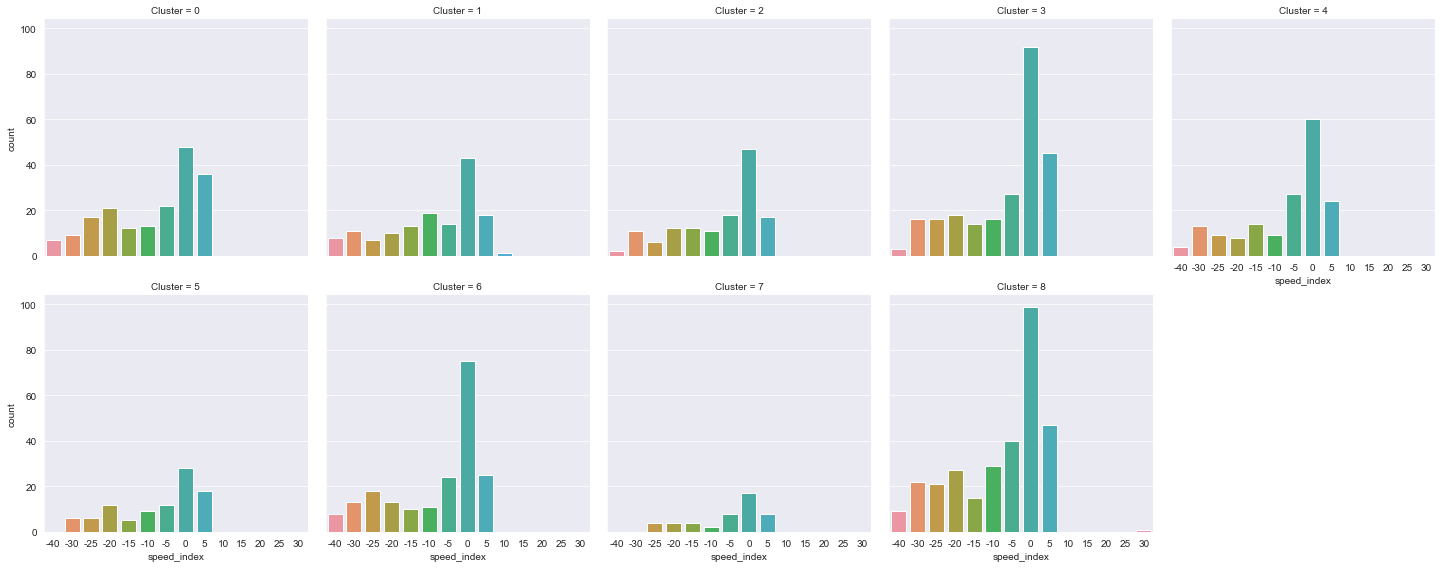

In [123]:
g = sns.factorplot(x='speed_index', col='Cluster', kind="count", data=df_comb, size=4,col_wrap=5)

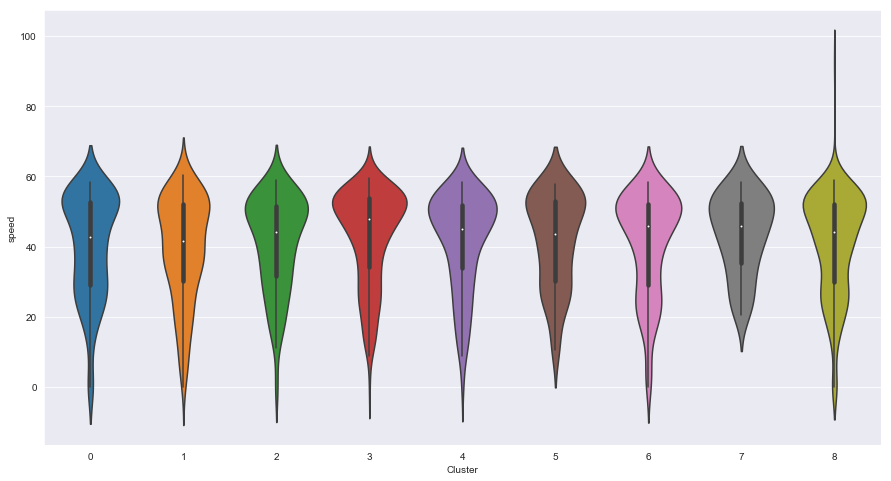

In [125]:
plt.figure(figsize=(15,8))
sns.violinplot(x='Cluster',y='speed', data=df_comb)
plt.show()

### Explore Mean Shift

In [126]:
bandwidth = estimate_bandwidth(X_sample, quantile=0.1, n_samples=500)
        
# Instantiating and fit_predicting model to then add to data frame
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)

# Calculate predicted values.
y_pred = ms.fit_predict(X_sample)

In [127]:
y = traffic_small[['SPEED','speed_index','ID']]

In [128]:
#Creating the dataframe for the cluster
df_clust = pd.DataFrame(y_pred)
df_clust.columns = ['Cluster']

In [129]:
# Combining the cluster to X values
df_comb = X_sample.join(df_clust, how='inner')
df_comb['speed'] = y['SPEED']
df_comb['speed_index'] = y['speed_index']
df_comb['speed_index_id'] = y['ID']
df_comb.head()

,ID,STATUS,LINK_ID,year,month,dayofweek,hour,minute,poly_num,speed_id,...,NonPed_codes,RB_Layer_codes,SegmentTyp_codes,FeatureTyp_codes,Street_codes,BOROUGH_codes,Cluster,speed,speed_index,speed_index_id
168307,424,0,4616300,2018,5,0,16,18,16,77399,...,1,1,1,0,26,3,5,26.71,-20,424
59292,423,0,4616299,2018,6,0,16,28,44,77399,...,1,1,1,0,26,3,3,34.79,-15,423
41088,423,0,4616299,2018,8,3,12,38,44,77399,...,1,1,1,0,26,3,2,23.61,-25,423
107279,424,0,4616300,2018,12,0,7,28,16,77399,...,1,1,1,0,26,3,3,31.06,-15,424
195779,424,0,4616300,2018,2,0,22,32,16,77399,...,1,1,1,0,26,3,1,52.19,0,424


/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


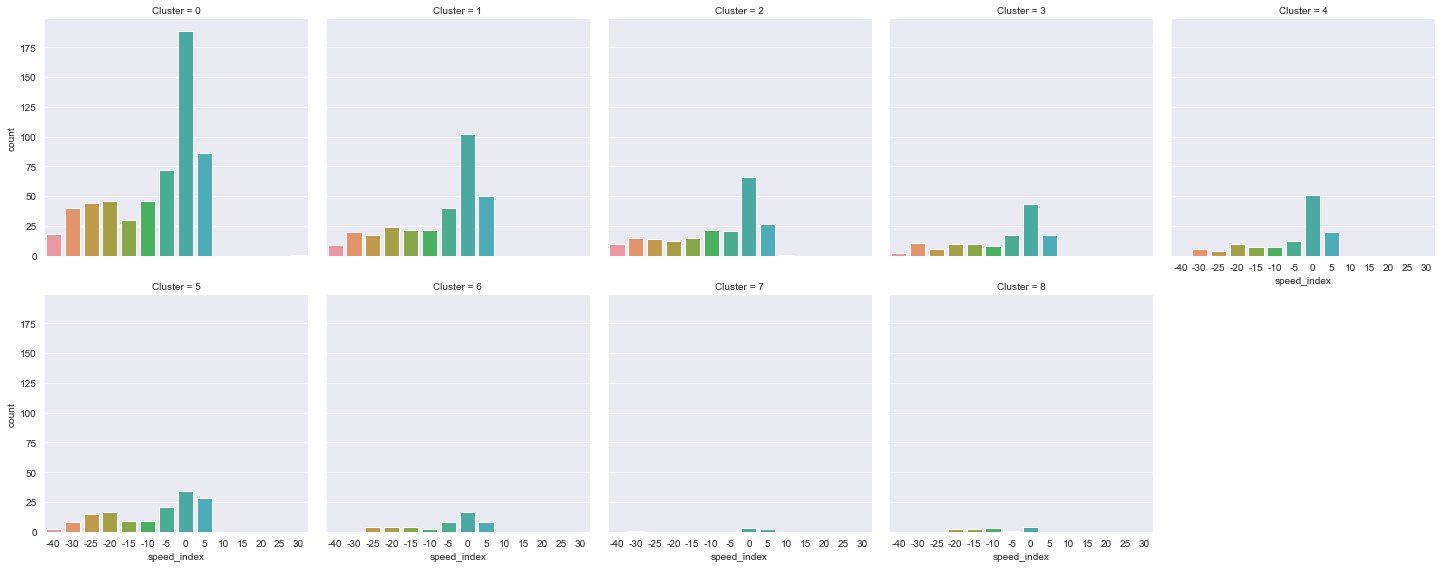

In [130]:
g = sns.factorplot(x='speed_index', col='Cluster', kind="count", data=df_comb, size=4,col_wrap=5)

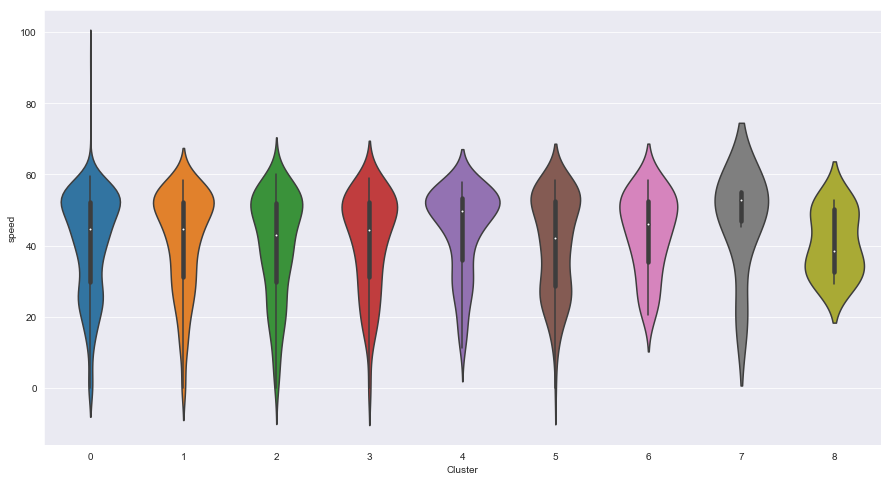

In [131]:
plt.figure(figsize=(15,8))
sns.violinplot(x='Cluster',y='speed', data=df_comb)
plt.show()